In [1]:
import warnings
warnings.filterwarnings('ignore')
#from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI
import numpy as np
import pandas as pd
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

#### 多模态检索

In [63]:
data = pd.read_csv('../dataset/Multimodal.csv')

In [67]:
query=data.iloc[25]
query
error_log=data

In [47]:
question_text = data['Question Text'].values[0]
image_path="../dataset/"+data['Image'].values[0]
options_text = data['Options'].values[0]
question="Question: "+ question_text+" Options:"+ options_text
question, image_path

("Question: Assume the prices are for settlement on June 1, 2005, today’s date. Assume semiannual coupon payments: Options:{'A': 'A. 0.9696/0.9858', 'B': 'B. 0.9858/0.9546', 'C': 'C. 0.9546/0.9696', 'D': 'D. 0.9778/0.9696'}",
 '../dataset/images/ValuationandRiskModels1_images/46u.png')

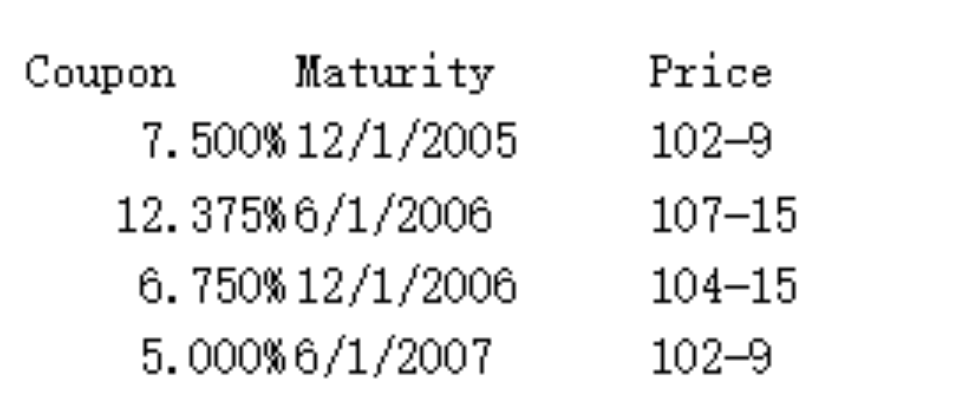

In [41]:
Image.open(image_path)

In [51]:
# 加载CLIP模型和处理器
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

question_text="Assume the prices are for settlement on June 1, 2005, today’s date. Assume semiannual coupon payments:"
options_text="{'A': 'A. 0.9696/0.9858', 'B': 'B. 0.9858/0.9546', 'C': 'C. 0.9546/0.9696', 'D': 'D. 0.9778/0.9696'}"
question="Question: "+ question_text+" Options:"+ options_text

# 处理图像，假设你有相关的图像文件
image_path="../dataset/images/ValuationandRiskModels1_images/46u.png"
image = Image.open(image_path)

# 生成文本和图像的嵌入，添加 truncation=True 和 max_length=77
inputs = processor(text=[question], images=image, return_tensors="pt", padding=True, truncation=True, max_length=77)

# 使用CLIP模型生成嵌入
outputs = model(**inputs)
image_embedding = outputs.image_embeds  # 图像嵌入
text_embedding = outputs.text_embeds  # 文本和选项嵌入

combined_embedding = torch.cat((text_embedding, image_embedding), dim=-1) # 将文本和图像嵌入连接在一起

In [61]:
import json

# 假设你已经为 error_log.json 中的每条数据生成了类似的多模态嵌入
with open('../dataset/multiDemo.json', 'r') as f:
    multiDemo = json.load(f)
da=multiDemo[0]
da

{'ID': 0,
 'Question Number': 1,
 'Share Context': 'Neshie Wakuluk is an investment strategist who develops capital market expectations for\nan investment firm that invests across asset classes and global markets. Wakuluk started her\ncareer when the global markets were experiencing significant volatility and poor returns; as a\nresult, she is now careful to base her conclusions on objective evidence and analytical\nprocedures to mitigate any potential biases.Wakuluk’s approach to economic forecasting\nutilizes a structural model in conjunction with a diffusion index to determine the current\nphase of a country’s business cycle. This approach has produced successful predictions in the\npast, thus Wakuluk has high confidence in the predictions. Wakuluk also determines whether any\nadjustments need to be made to her initial estimates of the respective aggregate economic\ngrowth trends based on historical rates of growth for Countries X and Y (both developed\nmarkets) and Country Z (a dev

In [62]:
da.get('Question Text')

'Wakuluk most likely seeks to mitigate which of the following biases in'

In [ ]:
def clipEmbedding(data):
    textdata="Question: "+ data.get('Question Text')+" Options:"+ data.get('Options')
    imagedata = Image.open('../dataset/'+image_path)
    inputs = processor(text=[textdata], images=imagedata, return_tensors="pt", padding=True, truncation=True, max_length=77)
    outputs = model(**inputs)
    image_embedding = outputs.image_embeds  # 图像嵌入
    text_embedding = outputs.text_embeds  # 文本和选项嵌入
    combined_embedding = torch.cat((text_embedding, image_embedding), dim=-1) # 将文本和图像嵌入连接在一起
    data['clipEmbedding']=combined_embedding
    return combined_embedding

In [53]:
import numpy as np

# 将图像和文本嵌入进行拼接
combined_embedding = torch.cat((text_embedding, image_embedding), dim=-1)

# 检查嵌入的形状，确保拼接成功
print(combined_embedding.shape)


torch.Size([1, 1024])


In [54]:
import json

# 假设你已经为 error_log.json 中的每条数据生成了类似的多模态嵌入
with open('error_log.json', 'r') as f:
    error_log = json.load(f)
error_log

{'ID': 2270,
 'Question Number': 107,
 'Share Context': '',
 'Share Image': '',
 'Question Text': 'Consider the expected returns and standard deviations for the following portfolios:',
 'Image': 'images/Foundationofriskmanagement1_images/107u.png',
 'Options': {'A': ' Portfolio 1',
  'B': ' Portfolio 2',
  'C': ' Portfolio 3',
  'D': ' Portfolio 4'},
 'Answer': 'A',
 'Explanation': 'Portfolio 1 is not efficient because it has a lower expected return and higher risk than Portfolios 2, 3, and 4. The portfolio is not mean variance efficient due to its suboptimal risk-return profile.',
 'QA Type': 'Knowledge reasoning QA',
 'Question Type': 'text+image',
 'Level of Difficulty': 'Easy',
 'Knowledge Topics': 'mean variance efficiency, portfolio analysis',
 'General Topics': 'Foundation of Risk Management',
 'Book Label': 'foundation of risk management1',
 'Wrong_answer': 'B',
 'Wrong_reasoning_steps': ['Step 1: I focused on finding the portfolio with the highest return for the least risk, wh

In [ ]:
import json

# 假设你已经为 error_log.json 中的每条数据生成了类似的多模态嵌入
with open('error_log.json', 'r') as f:
    error_log = json.load(f)

# 定义相似度计算函数（例如，余弦相似度）
def cosine_similarity(embedding1, embedding2):
    return torch.matmul(embedding1, embedding2.T) / (torch.norm(embedding1) * torch.norm(embedding2))

# 遍历 error_log 中的数据并计算相似度
best_match = None
best_similarity = -1

for entry in error_log:
    # 从error_log中获取文本和图像嵌入
    error_text_embedding = torch.tensor(entry["text_embedding"])  # 假设已有的文本嵌入
    error_image_embedding = torch.tensor(entry["image_embedding"])  # 假设已有的图像嵌入

    # 将文本和图像嵌入拼接
    error_combined_embedding = torch.cat((error_text_embedding, error_image_embedding), dim=-1)

    # 计算查询嵌入和错误日志嵌入之间的相似度
    similarity = cosine_similarity(combined_embedding, error_combined_embedding)

    # 找到最相似的条目
    if similarity > best_similarity:
        best_similarity = similarity
        best_match = entry

# 输出最相似的结果
print(f"Best match in error log: {best_match} with similarity score: {best_similarity}")
